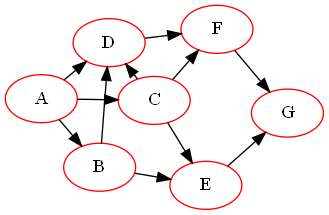

In [37]:
import pandas as pd
import pygraphviz as pgv
from IPython.display import Image

# 读取CSV文件
df = pd.read_csv('data.csv')

# 创建一个有向图
G = pgv.AGraph(directed=True)

# 遍历每一行数据，添加节点和边
for index, row in df.iterrows():
    node = row['活动']
    G.add_node(node, color='red')
    # 处理可能存在的多个紧前活动和紧后活动
    if pd.notnull(row['紧前活动']):
        predecessors = row['紧前活动'].split()
        for pre in predecessors:
            G.add_edge(pre, node)
    if pd.notnull(row['紧后活动']):
        successors = row['紧后活动'].split()
        for suc in successors:
            G.add_edge(node, suc)

# 使用neato布局绘制网络图
G.layout(prog='neato')
# 将图形保存为png图片
G.draw('graph1.png')

# 显示图片
Image(filename='graph1.png')


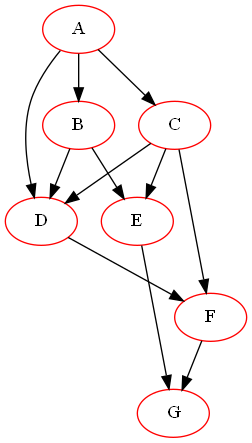

In [38]:
# 使用dot布局绘制网络图
G.layout(prog='dot')
# 将图形保存为png图片
G.draw('graph2.png')

Image(filename='graph2.png')

In [39]:
# 预处理数据
activities = df['活动'].unique()
activity_dict = {activity: {'duration': df[df['活动'] == activity]['持续时间'].values[0],
                            'predecessors': df[df['活动'] == activity]['紧前活动'].values[0].split() if pd.notnull(df[df['活动'] == activity]['紧前活动'].values[0]) else [],
                            'successors': df[df['活动'] == activity]['紧后活动'].values[0].split() if pd.notnull(df[df['活动'] == activity]['紧后活动'].values[0]) else []}
                 for activity in activities}


In [40]:
def calculate_parameters(df):
    # 预处理数据
    activities = df['活动'].unique()
    activity_dict = {activity: {'duration': df[df['活动'] == activity]['持续时间'].values[0],
                            'predecessors': df[df['活动'] == activity]['紧前活动'].values[0].split() if pd.notnull(df[df['活动'] == activity]['紧前活动'].values[0]) else [],
                            'successors': df[df['活动'] == activity]['紧后活动'].values[0].split() if pd.notnull(df[df['活动'] == activity]['紧后活动'].values[0]) else []}
                 for activity in activities}

    # 初始化参数
    for activity in activity_dict:
        activity_dict[activity]['ES'] = 0
        activity_dict[activity]['EF'] = 0
        activity_dict[activity]['LS'] = float('inf')
        activity_dict[activity]['LF'] = float('inf')
        activity_dict[activity]['TF'] = 0
        activity_dict[activity]['FF'] = 0

    # 计算ES和EF
    for activity in activity_dict:
        for predecessor in activity_dict[activity]['predecessors']:
            activity_dict[activity]['ES'] = max(activity_dict[activity]['ES'], activity_dict[predecessor]['EF'])
        activity_dict[activity]['EF'] = activity_dict[activity]['ES'] + activity_dict[activity]['duration']

    # 计算LS和LF
    for activity in reversed(list(activity_dict.keys())):
        for successor in activity_dict[activity]['successors']:
            activity_dict[activity]['LF'] = min(activity_dict[activity]['LF'], activity_dict[successor]['LS'])
        activity_dict[activity]['LS'] = activity_dict[activity]['LF'] - activity_dict[activity]['duration']

    # 计算TF和FF
    for activity in activity_dict:
        activity_dict[activity]['TF'] = activity_dict[activity]['LS'] - activity_dict[activity]['ES']
        for successor in activity_dict[activity]['successors']:
            activity_dict[activity]['FF'] = min(activity_dict[activity]['FF'], activity_dict[successor]['ES'] - activity_dict[activity]['EF'])

    return activity_dict


In [41]:
activity_dict = calculate_parameters(df)
print(activity_dict)

{'A': {'duration': 5, 'predecessors': [], 'successors': ['B', 'C', 'D'], 'ES': 0, 'EF': 5, 'LS': inf, 'LF': inf, 'TF': inf, 'FF': 0}, 'B': {'duration': 8, 'predecessors': ['A'], 'successors': ['E'], 'ES': 5, 'EF': 13, 'LS': inf, 'LF': inf, 'TF': inf, 'FF': 0}, 'C': {'duration': 2, 'predecessors': ['A'], 'successors': ['D'], 'ES': 5, 'EF': 7, 'LS': inf, 'LF': inf, 'TF': inf, 'FF': 0}, 'D': {'duration': 1, 'predecessors': ['B'], 'successors': [], 'ES': 13, 'EF': 14, 'LS': inf, 'LF': inf, 'TF': inf, 'FF': 0}, 'E': {'duration': 7, 'predecessors': ['B', 'C'], 'successors': ['G'], 'ES': 13, 'EF': 20, 'LS': inf, 'LF': inf, 'TF': inf, 'FF': 0}, 'F': {'duration': 8, 'predecessors': ['C', 'D'], 'successors': ['G'], 'ES': 14, 'EF': 22, 'LS': inf, 'LF': inf, 'TF': inf, 'FF': 0}, 'G': {'duration': 6, 'predecessors': ['E', 'F'], 'successors': [], 'ES': 22, 'EF': 28, 'LS': inf, 'LF': inf, 'TF': inf, 'FF': 0}}


In [50]:
def find_critical_path(df):
    # 预处理数据
    activities = df['活动'].unique()
    activity_dict = {activity: {'duration': df[df['活动'] == activity]['持续时间'].values[0],
                                'predecessors': df[df['活动'] == activity]['紧前活动'].values[0].split() if pd.notnull(df[df['活动'] == activity]['紧前活动'].values[0]) else [],
                                'successors': df[df['活动'] == activity]['紧后活动'].values[0].split() if pd.notnull(df[df['活动'] == activity]['紧后活动'].values[0]) else []}
                     for activity in activities}
    # 计算ES、EF、LS、LF
    activity_dict = calculate_parameters(df)

    # 找到关键路径
    critical_path = []
    nodes_without_successors = [node for node in activity_dict if not activity_dict[node]['successors']]
    current_node = min(nodes_without_successors, key=lambda x: activity_dict[x]['LF'])

    while current_node:
        critical_path.append(current_node)
        if activity_dict[current_node]['predecessors']:
            current_node = min(activity_dict[current_node]['predecessors'], key=lambda x: activity_dict[x]['LS'])
        else:
            current_node = None
    # critical_path.append[current_node]
    return list(reversed(critical_path))

# 使用示例
critical_path = find_critical_path(df)
print('关键路径:', '->'.join(critical_path))


关键路径: A->B->D
